### **Credit Card Fraud Detection**

# **1. Import libraries and load data**

In [184]:
import pandas as pd
import numpy as np
import seaborn as sb
import collections

import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [134]:
pd.options.display.float_format = '{:.2f}'.format

In [135]:
def read_dataset(file_path):
  return pd.read_csv(file_path)

In [136]:
df_credit = read_dataset('creditcard.csv')
df_credit.shape

(284807, 31)

# **2. Data Preprocessing**

In [137]:
df_credit.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [138]:
df_credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [139]:
df_credit.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [140]:
#check if there are null values
df_credit.isnull().sum().max()

#check which column(s) has null values
df_credit.columns[df_credit.isnull().any()].tolist()

[]

In [141]:
#get count of no fraud and fraud from 'Class' column to see the balance between the two classes (0 and 1)
percent_no_fraud = round(df_credit['Class'].value_counts()[0]/len(df_credit) * 100,2)
percent_fraud = round(df_credit['Class'].value_counts()[1]/len(df_credit) * 100,2)
count_no_fraud = df_credit['Class'].value_counts()[0]
count_fraud = df_credit['Class'].value_counts()[1]

In [142]:
print('Percentage of fraudulent transactions: ', percent_fraud)
print('Percentage of non-fraudulent transactions: ', percent_no_fraud)
print('Count of fraudulent transactions: ', count_fraud)
print('Count of non-fraudulent transactions: ', count_no_fraud)

Percentage of fraudulent transactions:  0.17
Percentage of non-fraudulent transactions:  99.83
Count of fraudulent transactions:  492
Count of non-fraudulent transactions:  284315


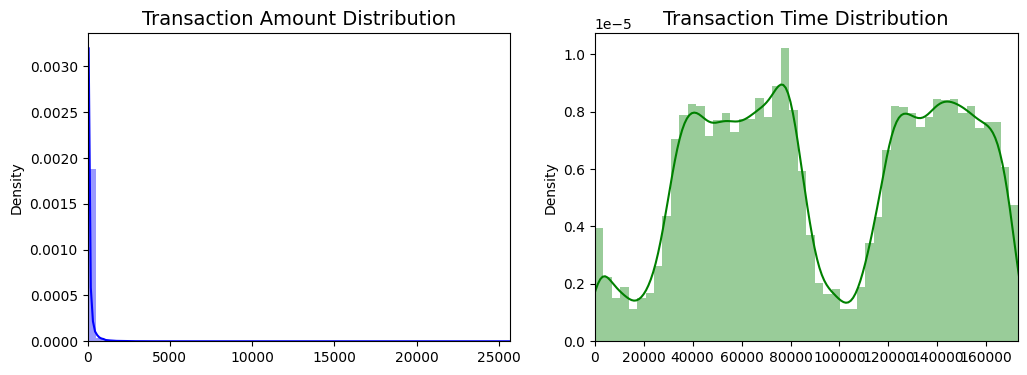

In [143]:
# plot distribution of transaction amount and transaction time
fig, ax = plt.subplots(1, 2, figsize=(12,4))

val_amt = df_credit['Amount'].values
sb.distplot(val_amt, ax=ax[0], color='b')
ax[0].set_title('Transaction Amount Distribution', fontsize=14)
ax[0].set_xlim([min(val_amt), max(val_amt)])


val_time = df_credit['Time'].values
sb.distplot(val_time, ax=ax[1], color='g')
ax[1].set_title('Transaction Time Distribution', fontsize=14)
ax[1].set_xlim([min(val_time), max(val_time)])

plt.show()

Columns Time and Amount need to be scaled, all other columns are values from PCA. Using Robust Scaler will help minimize the impact of outliers.

In [144]:
df_credit['Amount_scaled'] = RobustScaler().fit_transform(df_credit['Amount'].values.reshape(-1,1))
df_credit['Time_scaled'] = RobustScaler().fit_transform(df_credit['Time'].values.reshape(-1,1))
df_credit.drop(['Time','Amount'], axis=1, inplace=True)

In [145]:
df_credit.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Amount_scaled', 'Time_scaled'],
      dtype='object')

In [146]:
df_credit.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_scaled,Time_scaled
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,...,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.93,0.12
std,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,...,0.73,0.62,0.61,0.52,0.48,0.40,0.33,0.04,3.50,0.56
min,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,...,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,-0.31,-0.99
25%,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,...,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,0.00,-0.23,-0.36
50%,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,...,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,0.00,0.00,0.00
75%,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,...,0.53,0.15,0.44,0.35,0.24,0.09,0.08,0.00,0.77,0.64
max,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,...,10.50,22.53,4.58,7.52,3.52,31.61,33.85,1.00,358.68,1.04


In [147]:
amount_scaled = df_credit['Amount_scaled']
time_scaled = df_credit['Time_scaled']

df_credit.drop(['Amount_scaled', 'Time_scaled'], axis=1, inplace=True)
df_credit.insert(0, 'amount_scaled,',amount_scaled)
df_credit.insert(1, 'time_scaled', time_scaled)

df_credit.head()

,"amount_scaled,",time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.78,-0.99,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,...,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,0
1,-0.27,-0.99,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,...,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,0
2,4.98,-0.99,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,...,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,0
3,1.42,-0.99,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,...,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,0
4,0.67,-0.99,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,...,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,0


In [148]:
#split dataset into test and train
def data_split(df, n):
  X = df.drop('Class', axis=1)
  y = df['Class']
  split_data = StratifiedKFold(n_splits=n, random_state=None, shuffle=False)

  for train_idx, test_idx in split_data.split(X, y):
    org_Xtrain, org_Xtest = X.iloc[train_idx], X.iloc[test_idx]
    org_ytrain, org_ytest = y.iloc[train_idx], y.iloc[test_idx]

  org_Xtrain = org_Xtrain.values
  org_Xtest = org_Xtest.values
  org_ytrain = org_ytrain.values
  org_ytest = org_ytest.values

  train_unq_label, train_count_label = np.unique(org_ytrain, return_counts=True)
  test_unq_label, test_count_label = np.unique(org_ytest, return_counts=True)

  print('Label Distribution (Train):')
  print(train_count_label/ len(org_ytrain))
  print('\n')
  print('Label Distribution (Test):')
  print(test_count_label/ len(org_ytest))



In [149]:
data_split(df_credit, 5)

Label Distribution (Train):
[0.99827076 0.00172924]


Label Distribution (Test):
[0.99827952 0.00172048]


There are only 492 fraudulent transactions; and 284,315 non-fraudulent transactions. Undersampling the non-fraudulent class to correct imbalance in the dataset.

In [150]:
#shuffle dataframe
df_credit = df_credit.sample(frac = 1)

df_fraud = df_credit.loc[df_credit['Class'] == 1]
df_no_fraud = df_credit.loc[df_credit['Class'] == 0][:492]
df_norm_dist = pd.concat([df_fraud, df_no_fraud])

df_credit_rev = df_norm_dist.sample(frac=1, random_state=28)

In [151]:
df_credit_rev.head()

,"amount_scaled,",time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
201601,1.51,0.58,0.52,1.53,-4.18,3.58,-1.02,-0.50,-1.89,0.88,...,0.62,0.85,1.18,0.45,0.49,-0.50,-0.11,0.27,-0.06,1
42769,1.35,-0.51,-10.28,6.30,-13.27,8.93,-9.98,-2.83,-12.70,6.71,...,-0.25,2.48,0.37,0.04,0.48,0.16,0.33,0.16,-0.49,1
84543,6.05,-0.29,-3.98,0.58,-1.88,4.32,-3.02,1.24,-1.91,0.66,...,-0.66,0.58,1.40,1.05,-0.30,0.01,0.24,0.96,-0.67,1
27362,-0.29,-0.59,1.08,0.42,0.86,2.52,-0.01,0.56,-0.12,0.22,...,-0.17,-0.16,-0.31,0.05,0.01,0.38,-0.11,0.02,0.01,1
59286,2.38,-0.42,-1.09,-0.09,0.72,-0.69,-1.13,0.70,0.25,0.52,...,-0.48,-0.34,-0.56,0.58,-0.28,-0.83,0.93,-0.03,-0.02,0


In [152]:
df_credit_rev.shape

(984, 31)

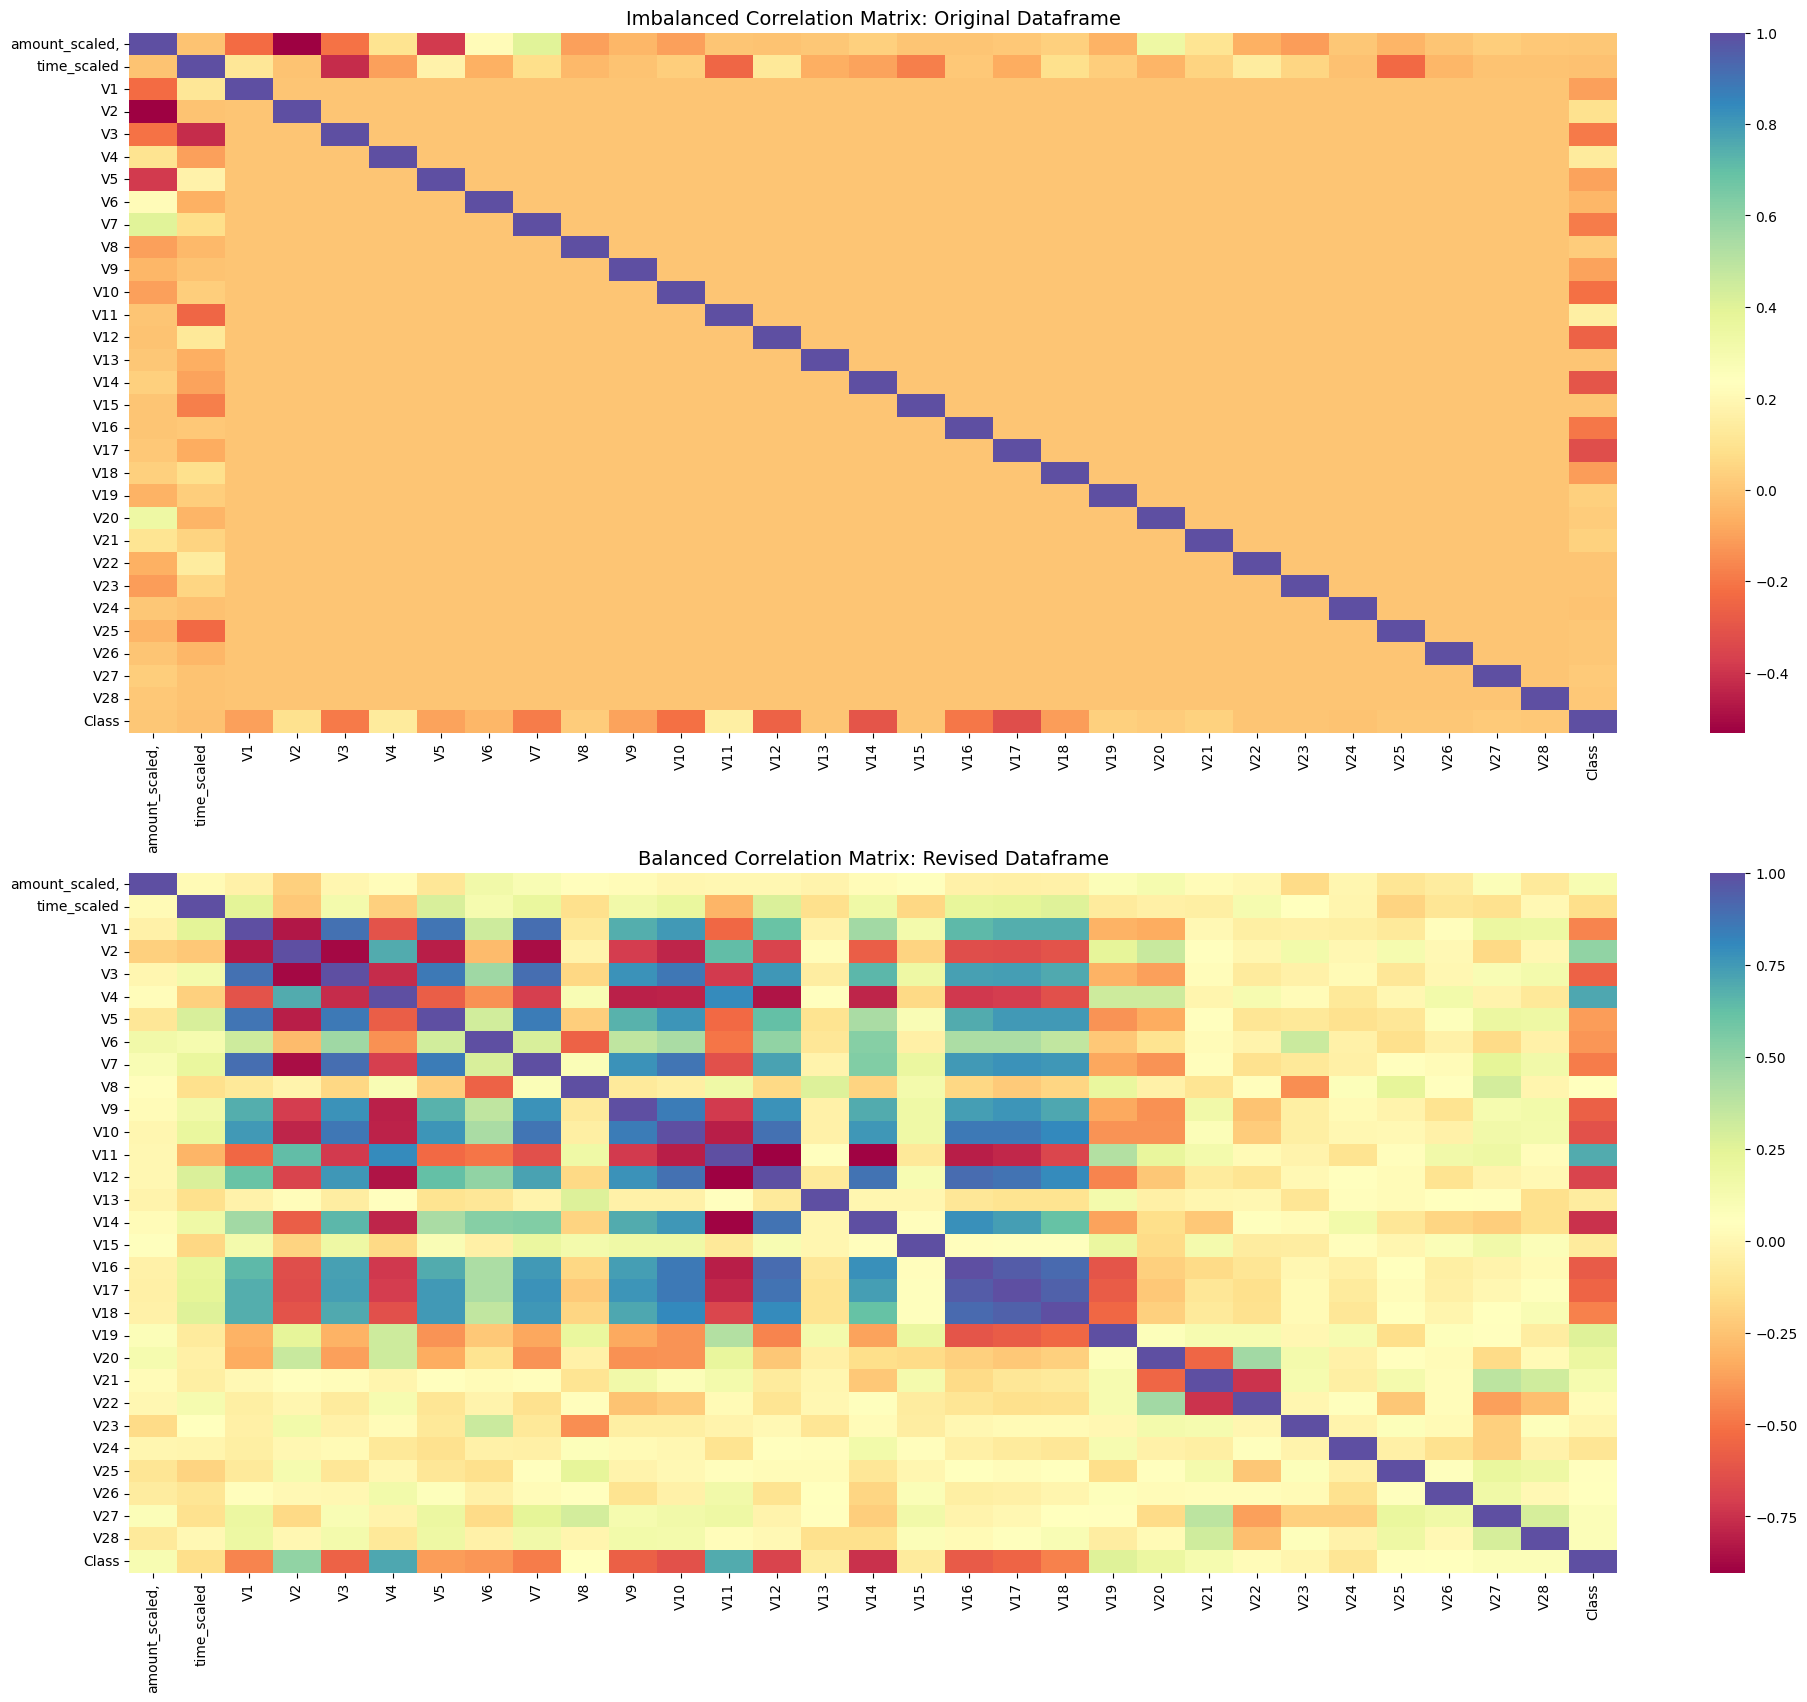

In [153]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df_credit.corr()
sb.heatmap(corr, cmap='Spectral', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix: Original Dataframe", fontsize=14)

corr_rev = df_credit_rev.corr()
sb.heatmap(corr_rev, cmap='Spectral', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Balanced Correlation Matrix: Revised Dataframe', fontsize=14)
plt.show()

# **3. Classifiers**

In [154]:
X = df_credit_rev.drop('Class', axis=1)
y = df_credit_rev['Class']

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [156]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

Logistic Regression and Decision Tree Classifiers

In [157]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [158]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "gives a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression gives a training score of 95.0 % accuracy score
Classifiers:  DecisionTreeClassifier gives a training score of 91.0 % accuracy score


In [159]:
#Logistic Regression with GridSearch
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

In [160]:
# DecisionTree Classifier with GridSearch
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [161]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.54%
DecisionTree Classifier Cross Validation Score 94.66%


In [162]:
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [165]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9785043469274393
Decision Tree Classifier:  0.9483180684915581


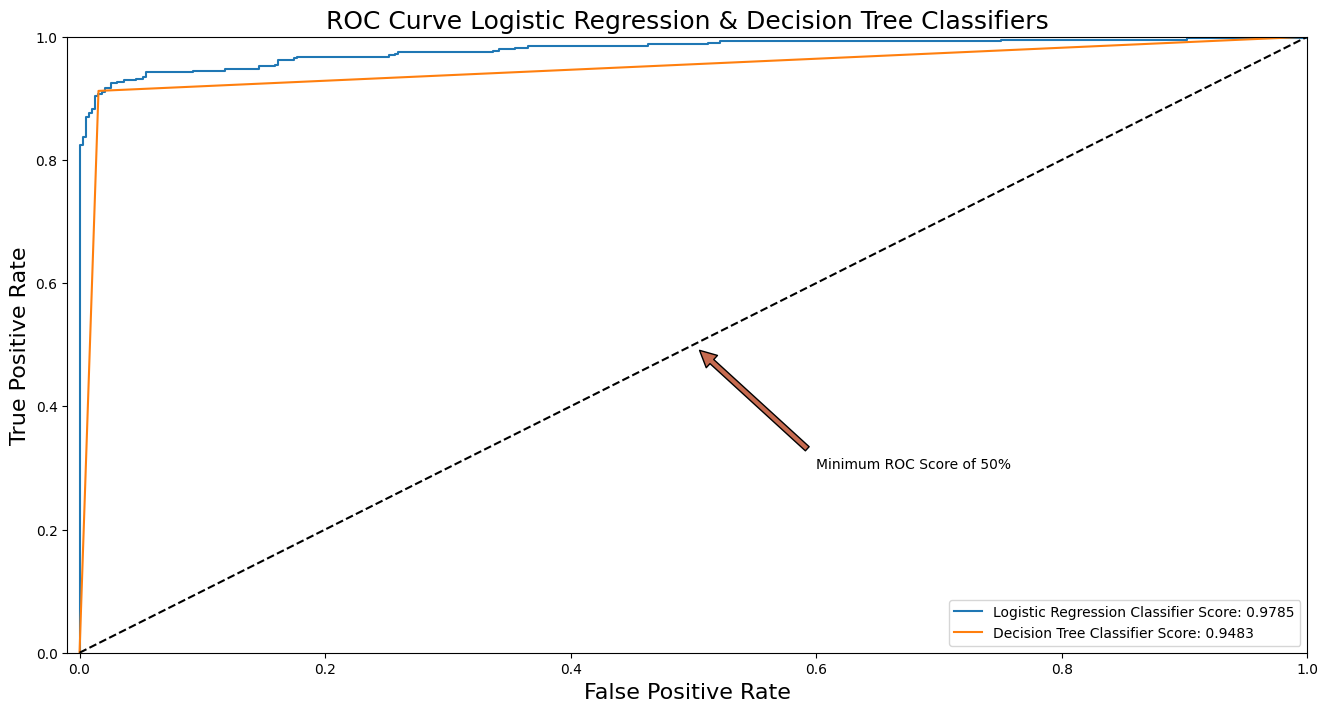

In [188]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve Logistic Regression & Decision Tree Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% ', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#C76B50', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, tree_fpr, tree_tpr)
plt.show()

In [186]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))
print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       103
           1       0.99      0.88      0.93        94

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       103
           1       0.96      0.84      0.90        94

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

In [176]:
xgb_predict = xgb_model.predict(X_test)

In [187]:
print('XGBoost Classifier:')
print(classification_report(y_test, xgb_predict))

XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       103
           1       0.93      0.90      0.92        94

    accuracy                           0.92       197
   macro avg       0.92      0.92      0.92       197
weighted avg       0.92      0.92      0.92       197

